<a href="https://colab.research.google.com/github/yuuto52925goal/inspo_categorize/blob/main/inspo_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import tensorflow as tf

def load_data(image_path, boxes):
  dataset = tf.data.Dataset.from_tensor_slices((image_path, boxes))

  def preprocess_image(image_path, box):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (400, 400))
    return image, box
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(1)
  return dataset

def build_model():
  base_model = tf.keras.applications.MobileNetV2(input_shape=(400, 400, 3), include_top=False, weights='imagenet')
  base_model.trainable = False

  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
  ])
  model.compile(optimizer='adam', loss='mse')
  return model


from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Jobs/Crop/'

dataset = load_data(
  [
      f'{data_dir}image2.JPG',
      f'{data_dir}image3.JPG',
      f'{data_dir}image4.JPG',
      f'{data_dir}image5.JPG',
      f'{data_dir}image6.JPG',
      f'{data_dir}image7.JPG',
  ],
  [
    [[0, 0, 320, 300], [70, 270, 370, 400], [0, 0, 0, 0], [0, 0, 0, 0]],
    [[80, 120, 380, 370], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    [[100, 180, 300, 330], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    [[130, 100, 260, 180], [130, 150, 260, 220], [130, 200, 260, 330], [0, 0, 0, 0]],
    [[100, 0, 300, 110], [100, 85, 300, 345], [100, 280, 300, 360], [0, 0, 0, 0]],
    [[140, 120, 250, 200], [140, 160, 250, 260], [140, 160, 250, 370], [140, 310, 250, 350]]
  ]
)

model = build_model()
model.fit(dataset, epochs=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-42-6a3ca3258504>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(400, 400, 3), include_top=False, weights='imagenet')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


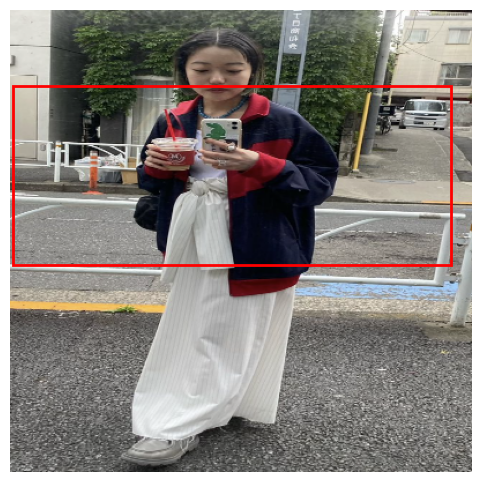

Predicted Bounding Boxes: [[-0.6387064  -0.24656127  0.55738163 -0.3229629 ]]


In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load a test image
test_image_path = '/content/drive/My Drive/Jobs/Crop/image9.png'

def preprocess_test_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  # Handles PNG and JPEG
    image = tf.image.resize(image, (400, 400))
    image = image / 255.0  # Normalize pixel values
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Preprocess the image
test_image = preprocess_test_image(test_image_path)

# Run inference
predicted_boxes = model.predict(test_image)

# Display results
def plot_image_with_boxes(image, boxes):
    image = tf.squeeze(image).numpy()  # Remove batch dimension and convert to NumPy
    image = (image * 255).astype("uint8")  # Convert back to standard pixel range

    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # boxes is already the single prediction with 4 values
    # Directly unpack it instead of iterating
    x1, y1, x2, y2 = boxes
    x1, y1, x2, y2 = ((x1 + 1) * 200) - 70, ((y1 + 1) * 200) + 70 , ((x2 + 1) * 200) + 70 , ((y2 + 1) * 200) -70

    if not all(v == 0 for v in boxes):  # Ignore empty boxes
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', linewidth=2))

    plt.axis("off")
    plt.show()

# Plot the test image with predicted bounding boxes
plot_image_with_boxes(test_image, predicted_boxes[0])

print("Predicted Bounding Boxes:", predicted_boxes)